# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",1000)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train__2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")

    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(25192, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]
    
    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

preprocess.x_train.shape

(25192, 122)

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 18

    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
            #hidden_encoder = tf.layers.dense(self.x, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            #hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(hidden_encoder, classes, activation=tf.nn.softmax)
            
        with tf.variable_scope("Loss"):
            
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            #loss = tf.clip_by_value(loss, -1e-1, 1e-1)
            #loss = tf.where(tf.is_nan(loss), 1e-1, loss)
            #loss = tf.where(tf.equal(loss, -1e-1), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-1), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'test_score_20', 'time_taken'])

    predictions = {}
    predictions_ = {}

    results = []
    
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_dense_only_nsl_kdd-/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                               net.regularized_loss, 
                                                               ], #net.summary_op
                                                              feed_dict={net.x: x_train[i,:], 
                                                                         net.y_: y_train[i,:], 
                                                                         net.keep_prob:0.5, net.lr:lr})

                        train_batch()
                        #summary_writer_train.add_summary(summary_str, epoch)
                        while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1):
                            print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_dense_only_nsl_kdd/hidden_layers_{}_features_count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()


                    valid_accuracy = sess.run(net.tf_accuracy, #net.summary_op 
                                                          feed_dict={net.x: x_valid, 
                                                                     net.y_: y_valid, 
                                                                     net.keep_prob:1, net.lr:lr})
                    #summary_writer_valid.add_summary(summary_str, epoch)


                    accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})
                    
                    accuracy_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test_, 
                                                                             net.y_: preprocess.y_test_, 
                                                                             net.keep_prob:1, net.lr:lr})

                    print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))
                    print("Accuracy on Test data: {}, {}".format(accuracy, accuracy_))

                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        Train.pred_value_ = pred_value_
                        Train.actual_value_ = actual_value_
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:
                        Train.best_acc = accuracy

                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_dense_only_nsl_kdd-/hidden_layers_{}_features_count_{}".format(h,f),
                                        global_step = epochs)
                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        curr_pred_ = pd.DataFrame({"Attack_prob":y_pred_[:,-2], "Normal_prob":y_pred_[:, -1], "Prediction":pred_value_})
                        
                        Train.predictions.update({"{}_{}_{}".format((epoch+1)*(c+1),f,h):(curr_pred,
                                                   Train.result((epoch+1)*(c+1), f, h, valid_accuracy, accuracy, accuracy_, time.perf_counter() - start_time))})
                        Train.predictions_.update({"{}_{}_{}".format((epoch+1)*(c+1),f,h):(curr_pred_,
                                                   Train.result((epoch+1)*(c+1), f, h, valid_accuracy, accuracy, accuracy_, time.perf_counter() - start_time))})

                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))


In [9]:
import itertools
df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():
        global df_results
        global past_scores
        
        features_arr = [1, 12, 24, 48, 122]
        hidden_layers_arr = [1, 3]

        Train.predictions = {}
        Train.results = []

        epochs = [10]
        lrs = [1e-5, 1e-6]
        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
        dict1 = {}
        dict1_ = {}

        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)
            
        for k, (v1_, v2) in Train.predictions.items():
            dict1_.update({k: v1_})

        Train.predictions = dict1
        Train.predictions_ = dict1_

        Train.results = dict2
        df_results = pd.DataFrame(Train.results)
        temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/scores/tf_dense_only_nsl_kdd_scores_all-.pkl'):
            past_scores = temp
        else:
            past_scores = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all-.pkl")

        past_scores.append(temp).to_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all-.pkl")


In [10]:
%%timeit -r 10
Hyperparameters.start_training()

Current Layer Attributes - epochs:10 hidden layers:1 features count:1
Step 1 | Training Loss: 0.696619 | Validation Accuracy: 0.621825
Accuracy on Test data: 0.6084102392196655, 0.39240506291389465
Step 2 | Training Loss: 0.630072 | Validation Accuracy: 0.742063
Accuracy on Test data: 0.68461674451828, 0.42683544754981995
Step 3 | Training Loss: 0.660342 | Validation Accuracy: 0.785714
Accuracy on Test data: 0.7082594037055969, 0.46000000834465027
Step 4 | Training Loss: 0.541829 | Validation Accuracy: 0.850000
Accuracy on Test data: 0.7194375395774841, 0.4780590832233429
Step 5 | Training Loss: 0.556526 | Validation Accuracy: 0.883333
Accuracy on Test data: 0.737358033657074, 0.5112236142158508
Step 6 | Training Loss: 0.485439 | Validation Accuracy: 0.897222
Accuracy on Test data: 0.7456085681915283, 0.5263291001319885
Step 7 | Training Loss: 0.474231 | Validation Accuracy: 0.915079
Accuracy on Test data: 0.7519074082374573, 0.5383122563362122
Step 8 | Training Loss: 0.492558 | Valida

Step 4 | Training Loss: 0.493843 | Validation Accuracy: 0.878571
Accuracy on Test data: 0.8600514531135559, 0.7566244602203369
Step 5 | Training Loss: 0.476521 | Validation Accuracy: 0.902778
Accuracy on Test data: 0.8636444211006165, 0.7553586363792419
Step 6 | Training Loss: 0.471299 | Validation Accuracy: 0.915873
Accuracy on Test data: 0.8704311847686768, 0.7649788856506348
Step 7 | Training Loss: 0.471719 | Validation Accuracy: 0.915079
Accuracy on Test data: 0.8685237765312195, 0.7594936490058899
Step 8 | Training Loss: 0.449003 | Validation Accuracy: 0.919841
Accuracy on Test data: 0.8554826378822327, 0.7325738668441772
Step 9 | Training Loss: 0.426383 | Validation Accuracy: 0.938889
Accuracy on Test data: 0.8494055867195129, 0.7194092869758606
Step 10 | Training Loss: 0.425396 | Validation Accuracy: 0.932936
Accuracy on Test data: 0.8455021381378174, 0.7108016610145569
Step 1 | Training Loss: 0.454522 | Validation Accuracy: 0.934524
Accuracy on Test data: 0.845014214515686, 0.7

Step 7 | Training Loss: 0.661561 | Validation Accuracy: 0.760714
Accuracy on Test data: 0.4975603222846985, 0.2282700389623642
Step 8 | Training Loss: 0.661222 | Validation Accuracy: 0.776190
Accuracy on Test data: 0.5193843245506287, 0.26455697417259216
Step 9 | Training Loss: 0.654404 | Validation Accuracy: 0.790873
Accuracy on Test data: 0.5501685738563538, 0.3206751048564911
Step 10 | Training Loss: 0.614166 | Validation Accuracy: 0.814286
Accuracy on Test data: 0.5615241527557373, 0.33890295028686523
Step 1 | Training Loss: 0.682278 | Validation Accuracy: 0.807540
Accuracy on Test data: 0.5623225569725037, 0.34008437395095825
Step 2 | Training Loss: 0.638704 | Validation Accuracy: 0.809921
Accuracy on Test data: 0.5632984638214111, 0.3416033685207367
Step 3 | Training Loss: 0.682334 | Validation Accuracy: 0.826984
Accuracy on Test data: 0.5640968680381775, 0.34286919236183167
Step 4 | Training Loss: 0.627990 | Validation Accuracy: 0.819048
Accuracy on Test data: 0.5651171207427979

Step 10 | Training Loss: 0.512662 | Validation Accuracy: 0.948413
Accuracy on Test data: 0.8140968680381775, 0.6498734354972839
Step 1 | Training Loss: 0.469955 | Validation Accuracy: 0.946032
Accuracy on Test data: 0.8139638304710388, 0.6496202349662781
Step 2 | Training Loss: 0.475418 | Validation Accuracy: 0.955159
Accuracy on Test data: 0.8139638304710388, 0.6496202349662781
Step 3 | Training Loss: 0.475644 | Validation Accuracy: 0.952778
Accuracy on Test data: 0.8140525221824646, 0.64970463514328
Step 4 | Training Loss: 0.483259 | Validation Accuracy: 0.953968
Accuracy on Test data: 0.8140525221824646, 0.6495358943939209
Step 5 | Training Loss: 0.450222 | Validation Accuracy: 0.946825
Accuracy on Test data: 0.8140968680381775, 0.6496202349662781
Step 6 | Training Loss: 0.518096 | Validation Accuracy: 0.952778
Accuracy on Test data: 0.8141412138938904, 0.64970463514328
Step 7 | Training Loss: 0.478529 | Validation Accuracy: 0.955159
Accuracy on Test data: 0.8140968680381775, 0.6496

Step 3 | Training Loss: 0.440137 | Validation Accuracy: 0.934921
Accuracy on Test data: 0.8452360033988953, 0.7135021090507507
Step 4 | Training Loss: 0.420628 | Validation Accuracy: 0.937302
Accuracy on Test data: 0.8447924256324768, 0.7125738263130188
Step 5 | Training Loss: 0.433634 | Validation Accuracy: 0.930952
Accuracy on Test data: 0.844481885433197, 0.7118143439292908
Step 6 | Training Loss: 0.388081 | Validation Accuracy: 0.925000
Accuracy on Test data: 0.8442157506942749, 0.7113080024719238
Step 7 | Training Loss: 0.419587 | Validation Accuracy: 0.925794
Accuracy on Test data: 0.8439939618110657, 0.7108860611915588
Step 8 | Training Loss: 0.436847 | Validation Accuracy: 0.931349
Accuracy on Test data: 0.8438165187835693, 0.7104641199111938
Step 9 | Training Loss: 0.415148 | Validation Accuracy: 0.932143
Accuracy on Test data: 0.8438608646392822, 0.7105485200881958
Step 10 | Training Loss: 0.437735 | Validation Accuracy: 0.931746
Accuracy on Test data: 0.8434616923332214, 0.7

Step 6 | Training Loss: 0.692460 | Validation Accuracy: 0.536508
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 7 | Training Loss: 0.692892 | Validation Accuracy: 0.535317
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 8 | Training Loss: 0.692780 | Validation Accuracy: 0.534127
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 9 | Training Loss: 0.692554 | Validation Accuracy: 0.540476
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 10 | Training Loss: 0.692773 | Validation Accuracy: 0.519048
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Current Layer Attributes - epochs:10 hidden layers:3 features count:12
Step 1 | Training Loss: 0.692682 | Validation Accuracy: 0.722619
Accuracy on Test data: 0.5186746120452881, 0.27468353509902954
Step 2 | Training Loss: 0.719414 | Validation Accuracy: 0.743254
Accuracy on Test data: 0.5526525974273682, 0.33544304966926575
Step 3 | Training Loss: 0.6

Step 9 | Training Loss: 0.515720 | Validation Accuracy: 0.925000
Accuracy on Test data: 0.8398687243461609, 0.7044726014137268
Step 10 | Training Loss: 0.535957 | Validation Accuracy: 0.925397
Accuracy on Test data: 0.8398243188858032, 0.7043038010597229
Current Layer Attributes - epochs:10 hidden layers:3 features count:122
Step 1 | Training Loss: 0.695120 | Validation Accuracy: 0.610317
Accuracy on Test data: 0.5602821111679077, 0.375189870595932
Step 2 | Training Loss: 0.660552 | Validation Accuracy: 0.815873
Accuracy on Test data: 0.7616660594940186, 0.5670042037963867
Step 3 | Training Loss: 0.623373 | Validation Accuracy: 0.882540
Accuracy on Test data: 0.8219038248062134, 0.6778903007507324
Step 4 | Training Loss: 0.629889 | Validation Accuracy: 0.897619
Accuracy on Test data: 0.8461675047874451, 0.7217721343040466
Step 5 | Training Loss: 0.626747 | Validation Accuracy: 0.902381
Accuracy on Test data: 0.8419091701507568, 0.7113924026489258
Step 6 | Training Loss: 0.573192 | Vali

Step 2 | Training Loss: 0.648512 | Validation Accuracy: 0.778968
Accuracy on Test data: 0.5994055867195129, 0.2605063319206238
Step 3 | Training Loss: 0.591696 | Validation Accuracy: 0.848016
Accuracy on Test data: 0.6419003009796143, 0.33763712644577026
Step 4 | Training Loss: 0.553540 | Validation Accuracy: 0.860714
Accuracy on Test data: 0.6633694171905518, 0.37586498260498047
Step 5 | Training Loss: 0.539500 | Validation Accuracy: 0.888889
Accuracy on Test data: 0.6876330971717834, 0.4174683690071106
Step 6 | Training Loss: 0.489102 | Validation Accuracy: 0.900000
Accuracy on Test data: 0.7014282941818237, 0.4421941041946411
Step 7 | Training Loss: 0.502714 | Validation Accuracy: 0.913492
Accuracy on Test data: 0.713981568813324, 0.46447256207466125
Step 8 | Training Loss: 0.455328 | Validation Accuracy: 0.938492
Accuracy on Test data: 0.7282203435897827, 0.4911392331123352
Step 9 | Training Loss: 0.461497 | Validation Accuracy: 0.937302
Accuracy on Test data: 0.7443665862083435, 0

Step 5 | Training Loss: 0.693126 | Validation Accuracy: 0.527381
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 6 | Training Loss: 0.692760 | Validation Accuracy: 0.527381
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 7 | Training Loss: 0.692908 | Validation Accuracy: 0.539286
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 8 | Training Loss: 0.693278 | Validation Accuracy: 0.537302
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 9 | Training Loss: 0.693475 | Validation Accuracy: 0.526984
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 10 | Training Loss: 0.691717 | Validation Accuracy: 0.525397
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 1 | Training Loss: 0.692407 | Validation Accuracy: 0.543254
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 2 | Training Loss: 0.693520 | Validation Accuracy: 0.534127
Accuracy on Test data: 0.430757

Step 8 | Training Loss: 0.637401 | Validation Accuracy: 0.890476
Accuracy on Test data: 0.8824077248573303, 0.7992405295372009
Step 9 | Training Loss: 0.524148 | Validation Accuracy: 0.898413
Accuracy on Test data: 0.8739354014396667, 0.7776371240615845
Step 10 | Training Loss: 0.566216 | Validation Accuracy: 0.903571
Accuracy on Test data: 0.8694996237754822, 0.7644725441932678
Step 1 | Training Loss: 0.540101 | Validation Accuracy: 0.914286
Accuracy on Test data: 0.8700762987136841, 0.7651476860046387
Step 2 | Training Loss: 0.552633 | Validation Accuracy: 0.908333
Accuracy on Test data: 0.8702980875968933, 0.7652320861816406
Step 3 | Training Loss: 0.564915 | Validation Accuracy: 0.905952
Accuracy on Test data: 0.8700319528579712, 0.7646413445472717
Step 4 | Training Loss: 0.519248 | Validation Accuracy: 0.913095
Accuracy on Test data: 0.8696770668029785, 0.7637974619865417
Step 5 | Training Loss: 0.550367 | Validation Accuracy: 0.913095
Accuracy on Test data: 0.8695883750915527, 0.

Step 1 | Training Loss: 0.438551 | Validation Accuracy: 0.942064
Accuracy on Test data: 0.7633960247039795, 0.5551055073738098
Step 2 | Training Loss: 0.441539 | Validation Accuracy: 0.933730
Accuracy on Test data: 0.7633516788482666, 0.5551055073738098
Step 3 | Training Loss: 0.420653 | Validation Accuracy: 0.943254
Accuracy on Test data: 0.763262927532196, 0.554852306842804
Step 4 | Training Loss: 0.466701 | Validation Accuracy: 0.945238
Accuracy on Test data: 0.7633073329925537, 0.5549367070198059
Step 5 | Training Loss: 0.443039 | Validation Accuracy: 0.956349
Accuracy on Test data: 0.7633960247039795, 0.5551055073738098
Step 6 | Training Loss: 0.424539 | Validation Accuracy: 0.949206
Accuracy on Test data: 0.7633073329925537, 0.5551055073738098
Step 7 | Training Loss: 0.437550 | Validation Accuracy: 0.942064
Accuracy on Test data: 0.7632185816764832, 0.554852306842804
Step 8 | Training Loss: 0.429481 | Validation Accuracy: 0.947222
Accuracy on Test data: 0.7632185816764832, 0.5546

Step 4 | Training Loss: 0.413689 | Validation Accuracy: 0.938889
Accuracy on Test data: 0.8135202527046204, 0.655105471611023
Step 5 | Training Loss: 0.419892 | Validation Accuracy: 0.937698
Accuracy on Test data: 0.8134315013885498, 0.6549367308616638
Step 6 | Training Loss: 0.439355 | Validation Accuracy: 0.949603
Accuracy on Test data: 0.8133871555328369, 0.6547679305076599
Step 7 | Training Loss: 0.380982 | Validation Accuracy: 0.942460
Accuracy on Test data: 0.8132984638214111, 0.654599130153656
Step 8 | Training Loss: 0.442472 | Validation Accuracy: 0.949206
Accuracy on Test data: 0.8131210207939148, 0.654261589050293
Step 9 | Training Loss: 0.425359 | Validation Accuracy: 0.949206
Accuracy on Test data: 0.8130766749382019, 0.654177188873291
Step 10 | Training Loss: 0.427421 | Validation Accuracy: 0.947619
Accuracy on Test data: 0.8134315013885498, 0.6548523306846619
Current Layer Attributes - epochs:10 hidden layers:3 features count:1
Step 1 | Training Loss: 0.693063 | Validatio

Step 7 | Training Loss: 0.599622 | Validation Accuracy: 0.892857
Accuracy on Test data: 0.6985006928443909, 0.4378059208393097
Step 8 | Training Loss: 0.584390 | Validation Accuracy: 0.892063
Accuracy on Test data: 0.7002306580543518, 0.44109705090522766
Step 9 | Training Loss: 0.572836 | Validation Accuracy: 0.896032
Accuracy on Test data: 0.7011178135871887, 0.4427848160266876
Step 10 | Training Loss: 0.581638 | Validation Accuracy: 0.893651
Accuracy on Test data: 0.7020049691200256, 0.44438818097114563
Current Layer Attributes - epochs:10 hidden layers:3 features count:48
Step 1 | Training Loss: 0.674120 | Validation Accuracy: 0.672619
Accuracy on Test data: 0.5823279023170471, 0.6183122396469116
Step 2 | Training Loss: 0.651275 | Validation Accuracy: 0.822222
Accuracy on Test data: 0.7797196507453918, 0.6556118130683899
Step 3 | Training Loss: 0.629393 | Validation Accuracy: 0.832937
Accuracy on Test data: 0.8017654418945312, 0.6791561245918274
Step 4 | Training Loss: 0.631256 | Va

Step 10 | Training Loss: 0.439268 | Validation Accuracy: 0.945635
Accuracy on Test data: 0.801543653011322, 0.6267510652542114
Current Layer Attributes - epochs:10 hidden layers:1 features count:12
Step 1 | Training Loss: 0.700626 | Validation Accuracy: 0.542857
Accuracy on Test data: 0.4536462128162384, 0.2205907106399536
Step 2 | Training Loss: 0.683508 | Validation Accuracy: 0.682936
Accuracy on Test data: 0.5147267580032349, 0.2600843906402588
Step 3 | Training Loss: 0.686013 | Validation Accuracy: 0.715873
Accuracy on Test data: 0.6344481706619263, 0.325654000043869
Step 4 | Training Loss: 0.640443 | Validation Accuracy: 0.767063
Accuracy on Test data: 0.6586231589317322, 0.3670042157173157
Step 5 | Training Loss: 0.574762 | Validation Accuracy: 0.800000
Accuracy on Test data: 0.6729950308799744, 0.3911392390727997
Step 6 | Training Loss: 0.582021 | Validation Accuracy: 0.838492
Accuracy on Test data: 0.7015613913536072, 0.4430379867553711
Step 7 | Training Loss: 0.554168 | Valida

Step 3 | Training Loss: 0.576643 | Validation Accuracy: 0.841667
Accuracy on Test data: 0.8094836473464966, 0.6539240479469299
Step 4 | Training Loss: 0.549837 | Validation Accuracy: 0.875397
Accuracy on Test data: 0.8215045928955078, 0.6715611815452576
Step 5 | Training Loss: 0.547593 | Validation Accuracy: 0.896429
Accuracy on Test data: 0.8250975608825684, 0.6755274534225464
Step 6 | Training Loss: 0.455088 | Validation Accuracy: 0.916667
Accuracy on Test data: 0.8275372385978699, 0.6789029240608215
Step 7 | Training Loss: 0.501299 | Validation Accuracy: 0.919048
Accuracy on Test data: 0.8270936608314514, 0.6775527596473694
Step 8 | Training Loss: 0.488933 | Validation Accuracy: 0.921429
Accuracy on Test data: 0.8265170454978943, 0.6763713359832764
Step 9 | Training Loss: 0.482712 | Validation Accuracy: 0.929762
Accuracy on Test data: 0.8267831802368164, 0.6766244769096375
Step 10 | Training Loss: 0.431244 | Validation Accuracy: 0.934524
Accuracy on Test data: 0.8253637552261353, 0.

Step 6 | Training Loss: 0.646630 | Validation Accuracy: 0.838492
Accuracy on Test data: 0.728087306022644, 0.5083544254302979
Step 7 | Training Loss: 0.636528 | Validation Accuracy: 0.884524
Accuracy on Test data: 0.7571859359741211, 0.5584810376167297
Step 8 | Training Loss: 0.579515 | Validation Accuracy: 0.884921
Accuracy on Test data: 0.7667228579521179, 0.5735021233558655
Step 9 | Training Loss: 0.686004 | Validation Accuracy: 0.890873
Accuracy on Test data: 0.7826029062271118, 0.6016877889633179
Step 10 | Training Loss: 0.598271 | Validation Accuracy: 0.899603
Accuracy on Test data: 0.797817587852478, 0.6291139125823975
Step 1 | Training Loss: 0.617785 | Validation Accuracy: 0.900794
Accuracy on Test data: 0.7989708781242371, 0.6311392188072205
Step 2 | Training Loss: 0.648395 | Validation Accuracy: 0.919048
Accuracy on Test data: 0.7991039752960205, 0.6313924193382263
Step 3 | Training Loss: 0.620021 | Validation Accuracy: 0.901984
Accuracy on Test data: 0.7996362447738647, 0.63

Step 9 | Training Loss: 0.466108 | Validation Accuracy: 0.942064
Accuracy on Test data: 0.7419712543487549, 0.5174683332443237
Step 10 | Training Loss: 0.417791 | Validation Accuracy: 0.930159
Accuracy on Test data: 0.7490684986114502, 0.5292826890945435
Step 1 | Training Loss: 0.448633 | Validation Accuracy: 0.939286
Accuracy on Test data: 0.7492902874946594, 0.5297046303749084
Step 2 | Training Loss: 0.414845 | Validation Accuracy: 0.936508
Accuracy on Test data: 0.7496007680892944, 0.5302109718322754
Step 3 | Training Loss: 0.450315 | Validation Accuracy: 0.945635
Accuracy on Test data: 0.7499556541442871, 0.5307173132896423
Step 4 | Training Loss: 0.427583 | Validation Accuracy: 0.936111
Accuracy on Test data: 0.7502217888832092, 0.5312236547470093
Step 5 | Training Loss: 0.433311 | Validation Accuracy: 0.938492
Accuracy on Test data: 0.7501774430274963, 0.5311392545700073
Step 6 | Training Loss: 0.462555 | Validation Accuracy: 0.925397
Accuracy on Test data: 0.7503548860549927, 0.

Step 2 | Training Loss: 0.425381 | Validation Accuracy: 0.946825
Accuracy on Test data: 0.8520670533180237, 0.7224472761154175
Step 3 | Training Loss: 0.426639 | Validation Accuracy: 0.947222
Accuracy on Test data: 0.8518896102905273, 0.7221096754074097
Step 4 | Training Loss: 0.435035 | Validation Accuracy: 0.944841
Accuracy on Test data: 0.8516234755516052, 0.7216033935546875
Step 5 | Training Loss: 0.413669 | Validation Accuracy: 0.945238
Accuracy on Test data: 0.8517122268676758, 0.7216033935546875
Step 6 | Training Loss: 0.416473 | Validation Accuracy: 0.951984
Accuracy on Test data: 0.8514904379844666, 0.7209282517433167
Step 7 | Training Loss: 0.425263 | Validation Accuracy: 0.951984
Accuracy on Test data: 0.8513129949569702, 0.7204219698905945
Step 8 | Training Loss: 0.417076 | Validation Accuracy: 0.955556
Accuracy on Test data: 0.8506476283073425, 0.7190717458724976
Step 9 | Training Loss: 0.394421 | Validation Accuracy: 0.946429
Accuracy on Test data: 0.8500709533691406, 0.7

Step 5 | Training Loss: 0.649242 | Validation Accuracy: 0.868254
Accuracy on Test data: 0.6862136125564575, 0.42059072852134705
Step 6 | Training Loss: 0.676349 | Validation Accuracy: 0.870635
Accuracy on Test data: 0.687189519405365, 0.4221096932888031
Step 7 | Training Loss: 0.662504 | Validation Accuracy: 0.852381
Accuracy on Test data: 0.6880766749382019, 0.4232911467552185
Step 8 | Training Loss: 0.646080 | Validation Accuracy: 0.864286
Accuracy on Test data: 0.6890968680381775, 0.42497891187667847
Step 9 | Training Loss: 0.629912 | Validation Accuracy: 0.854365
Accuracy on Test data: 0.6899840235710144, 0.4265822768211365
Step 10 | Training Loss: 0.650375 | Validation Accuracy: 0.865873
Accuracy on Test data: 0.691226065158844, 0.4287763833999634
Current Layer Attributes - epochs:10 hidden layers:3 features count:24
Step 1 | Training Loss: 0.725629 | Validation Accuracy: 0.722619
Accuracy on Test data: 0.7485361695289612, 0.6205063462257385
Step 2 | Training Loss: 0.728004 | Vali

Step 8 | Training Loss: 0.444935 | Validation Accuracy: 0.961905
Accuracy on Test data: 0.7979506850242615, 0.6192405223846436
Step 9 | Training Loss: 0.458315 | Validation Accuracy: 0.953571
Accuracy on Test data: 0.7983942627906799, 0.6200844049453735
Step 10 | Training Loss: 0.439899 | Validation Accuracy: 0.955556
Accuracy on Test data: 0.7988821864128113, 0.6210126876831055
Current Layer Attributes - epochs:10 hidden layers:1 features count:1
Step 1 | Training Loss: 0.664869 | Validation Accuracy: 0.497222
Accuracy on Test data: 0.4430890679359436, 0.5031223893165588
Step 2 | Training Loss: 0.646337 | Validation Accuracy: 0.781746
Accuracy on Test data: 0.7225425839424133, 0.5286920070648193
Step 3 | Training Loss: 0.581629 | Validation Accuracy: 0.834921
Accuracy on Test data: 0.7565649151802063, 0.550717294216156
Step 4 | Training Loss: 0.533676 | Validation Accuracy: 0.861111
Accuracy on Test data: 0.7666341662406921, 0.5647257566452026
Step 5 | Training Loss: 0.532177 | Valida

Current Layer Attributes - epochs:10 hidden layers:1 features count:48
Step 1 | Training Loss: 0.612803 | Validation Accuracy: 0.754762
Accuracy on Test data: 0.7948012948036194, 0.6987341642379761
Step 2 | Training Loss: 0.580267 | Validation Accuracy: 0.794444
Accuracy on Test data: 0.8097941875457764, 0.7043038010597229
Step 3 | Training Loss: 0.561358 | Validation Accuracy: 0.874603
Accuracy on Test data: 0.839292049407959, 0.7158649563789368
Step 4 | Training Loss: 0.496500 | Validation Accuracy: 0.896825
Accuracy on Test data: 0.8457682728767395, 0.7212658524513245
Step 5 | Training Loss: 0.496553 | Validation Accuracy: 0.913095
Accuracy on Test data: 0.8356547355651855, 0.6999155879020691
Step 6 | Training Loss: 0.454943 | Validation Accuracy: 0.926190
Accuracy on Test data: 0.8326383829116821, 0.6914768218994141
Step 7 | Training Loss: 0.404323 | Validation Accuracy: 0.915873
Accuracy on Test data: 0.8317955732345581, 0.6894514560699463
Step 8 | Training Loss: 0.418696 | Valida

Step 3 | Training Loss: 0.659383 | Validation Accuracy: 0.818651
Accuracy on Test data: 0.8191536664962769, 0.6737552881240845
Step 4 | Training Loss: 0.709997 | Validation Accuracy: 0.841270
Accuracy on Test data: 0.8188875317573547, 0.6703797578811646
Step 5 | Training Loss: 0.704000 | Validation Accuracy: 0.846825
Accuracy on Test data: 0.8144960999488831, 0.6606751084327698
Step 6 | Training Loss: 0.643223 | Validation Accuracy: 0.856746
Accuracy on Test data: 0.8156050443649292, 0.6619409322738647
Step 7 | Training Loss: 0.648264 | Validation Accuracy: 0.873016
Accuracy on Test data: 0.8179559707641602, 0.6655696034431458
Step 8 | Training Loss: 0.660275 | Validation Accuracy: 0.882540
Accuracy on Test data: 0.8220369219779968, 0.6727426052093506
Step 9 | Training Loss: 0.628110 | Validation Accuracy: 0.896032
Accuracy on Test data: 0.8214602470397949, 0.6711392402648926
Step 10 | Training Loss: 0.655740 | Validation Accuracy: 0.918254
Accuracy on Test data: 0.819730281829834, 0.6

Step 6 | Training Loss: 0.519842 | Validation Accuracy: 0.922619
Accuracy on Test data: 0.8354772925376892, 0.699240505695343
Step 7 | Training Loss: 0.522926 | Validation Accuracy: 0.934921
Accuracy on Test data: 0.833215057849884, 0.6945147514343262
Step 8 | Training Loss: 0.486926 | Validation Accuracy: 0.929762
Accuracy on Test data: 0.8254967927932739, 0.6791561245918274
Step 9 | Training Loss: 0.508210 | Validation Accuracy: 0.931746
Accuracy on Test data: 0.824609637260437, 0.6770464181900024
Step 10 | Training Loss: 0.457895 | Validation Accuracy: 0.925794
Accuracy on Test data: 0.8247427344322205, 0.6769620180130005
Step 1 | Training Loss: 0.468962 | Validation Accuracy: 0.935317
Accuracy on Test data: 0.8247427344322205, 0.6769620180130005
Step 2 | Training Loss: 0.497946 | Validation Accuracy: 0.934921
Accuracy on Test data: 0.8245652914047241, 0.6763713359832764
Step 3 | Training Loss: 0.462751 | Validation Accuracy: 0.938095
Accuracy on Test data: 0.8245652914047241, 0.676

Step 9 | Training Loss: 0.503093 | Validation Accuracy: 0.922619
Accuracy on Test data: 0.7600248456001282, 0.552827000617981
Step 10 | Training Loss: 0.475460 | Validation Accuracy: 0.925397
Accuracy on Test data: 0.7623314261436462, 0.5570464134216309
Step 1 | Training Loss: 0.476315 | Validation Accuracy: 0.928571
Accuracy on Test data: 0.7625532150268555, 0.5573839545249939
Step 2 | Training Loss: 0.480512 | Validation Accuracy: 0.927778
Accuracy on Test data: 0.7629967927932739, 0.5581434369087219
Step 3 | Training Loss: 0.439609 | Validation Accuracy: 0.933730
Accuracy on Test data: 0.7639282941818237, 0.5599156022071838
Step 4 | Training Loss: 0.442043 | Validation Accuracy: 0.935714
Accuracy on Test data: 0.7649042010307312, 0.5617721676826477
Step 5 | Training Loss: 0.444520 | Validation Accuracy: 0.933730
Accuracy on Test data: 0.7654364705085754, 0.5627847909927368
Step 6 | Training Loss: 0.468808 | Validation Accuracy: 0.928571
Accuracy on Test data: 0.7659687995910645, 0.5

Step 2 | Training Loss: 0.692514 | Validation Accuracy: 0.530159
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 3 | Training Loss: 0.692609 | Validation Accuracy: 0.534127
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 4 | Training Loss: 0.692604 | Validation Accuracy: 0.525794
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 5 | Training Loss: 0.692804 | Validation Accuracy: 0.559127
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 6 | Training Loss: 0.692801 | Validation Accuracy: 0.540476
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 7 | Training Loss: 0.692379 | Validation Accuracy: 0.522222
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 8 | Training Loss: 0.693112 | Validation Accuracy: 0.540873
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 9 | Training Loss: 0.692899 | Validation Accuracy: 0.532937
Accuracy on Test data: 0.4307576

Step 5 | Training Loss: 0.559182 | Validation Accuracy: 0.927778
Accuracy on Test data: 0.8289567232131958, 0.6858227849006653
Step 6 | Training Loss: 0.517693 | Validation Accuracy: 0.922619
Accuracy on Test data: 0.828646183013916, 0.6852320432662964
Step 7 | Training Loss: 0.510088 | Validation Accuracy: 0.928571
Accuracy on Test data: 0.8281582593917847, 0.6842194199562073
Step 8 | Training Loss: 0.552179 | Validation Accuracy: 0.928571
Accuracy on Test data: 0.8279364705085754, 0.6837974786758423
Step 9 | Training Loss: 0.494122 | Validation Accuracy: 0.934524
Accuracy on Test data: 0.8276703357696533, 0.6832911372184753
Step 10 | Training Loss: 0.566281 | Validation Accuracy: 0.936905
Accuracy on Test data: 0.8273154497146606, 0.6825316548347473
Current Layer Attributes - epochs:10 hidden layers:3 features count:122
Step 1 | Training Loss: 0.725356 | Validation Accuracy: 0.722619
Accuracy on Test data: 0.7666341662406921, 0.8214346170425415
Step 2 | Training Loss: 0.667352 | Vali

Step 8 | Training Loss: 0.429061 | Validation Accuracy: 0.964286
Accuracy on Test data: 0.7731990814208984, 0.5709704756736755
Step 9 | Training Loss: 0.422732 | Validation Accuracy: 0.964286
Accuracy on Test data: 0.7732434272766113, 0.5710548758506775
Step 10 | Training Loss: 0.401546 | Validation Accuracy: 0.968254
Accuracy on Test data: 0.7732877731323242, 0.5711392164230347
Current Layer Attributes - epochs:10 hidden layers:1 features count:24
Step 1 | Training Loss: 0.658309 | Validation Accuracy: 0.735714
Accuracy on Test data: 0.5419623851776123, 0.3677637279033661
Step 2 | Training Loss: 0.594321 | Validation Accuracy: 0.802778
Accuracy on Test data: 0.5953690409660339, 0.4212658107280731
Step 3 | Training Loss: 0.553387 | Validation Accuracy: 0.832540
Accuracy on Test data: 0.6125354766845703, 0.4359493553638458
Step 4 | Training Loss: 0.570066 | Validation Accuracy: 0.885714
Accuracy on Test data: 0.7151792049407959, 0.4710548520088196
Step 5 | Training Loss: 0.517392 | Vali

Current Layer Attributes - epochs:10 hidden layers:3 features count:1
Step 1 | Training Loss: 0.693343 | Validation Accuracy: 0.599603
Accuracy on Test data: 0.4595457911491394, 0.23383966088294983
Step 2 | Training Loss: 0.690998 | Validation Accuracy: 0.657143
Accuracy on Test data: 0.4950762987136841, 0.29924049973487854
Step 3 | Training Loss: 0.685526 | Validation Accuracy: 0.755556
Accuracy on Test data: 0.5516323447227478, 0.3321518898010254
Step 4 | Training Loss: 0.692359 | Validation Accuracy: 0.765079
Accuracy on Test data: 0.5843240022659302, 0.36303797364234924
Step 5 | Training Loss: 0.690848 | Validation Accuracy: 0.808730
Accuracy on Test data: 0.6439850926399231, 0.40042194724082947
Step 6 | Training Loss: 0.679884 | Validation Accuracy: 0.835317
Accuracy on Test data: 0.6851934194564819, 0.42219409346580505
Step 7 | Training Loss: 0.680988 | Validation Accuracy: 0.851587
Accuracy on Test data: 0.6922906041145325, 0.43426159024238586
Step 8 | Training Loss: 0.677236 | 

Step 4 | Training Loss: 0.678400 | Validation Accuracy: 0.862698
Accuracy on Test data: 0.8813875317573547, 0.8142616152763367
Step 5 | Training Loss: 0.628679 | Validation Accuracy: 0.867063
Accuracy on Test data: 0.8727377653121948, 0.7875949144363403
Step 6 | Training Loss: 0.607436 | Validation Accuracy: 0.904762
Accuracy on Test data: 0.8797906041145325, 0.7826160192489624
Step 7 | Training Loss: 0.576137 | Validation Accuracy: 0.913492
Accuracy on Test data: 0.8793026804924011, 0.7783122658729553
Step 8 | Training Loss: 0.548365 | Validation Accuracy: 0.921825
Accuracy on Test data: 0.8712295889854431, 0.7618565559387207
Step 9 | Training Loss: 0.572935 | Validation Accuracy: 0.930159
Accuracy on Test data: 0.8602288961410522, 0.7408438920974731
Step 10 | Training Loss: 0.567939 | Validation Accuracy: 0.936111
Accuracy on Test data: 0.8518452644348145, 0.7247257232666016
Step 1 | Training Loss: 0.564364 | Validation Accuracy: 0.936508
Accuracy on Test data: 0.8513573408126831, 0.

Step 7 | Training Loss: 0.507726 | Validation Accuracy: 0.896032
Accuracy on Test data: 0.7117193341255188, 0.4591561257839203
Step 8 | Training Loss: 0.465859 | Validation Accuracy: 0.906349
Accuracy on Test data: 0.7245830297470093, 0.4819409251213074
Step 9 | Training Loss: 0.467561 | Validation Accuracy: 0.923016
Accuracy on Test data: 0.7351401448249817, 0.5017721652984619
Step 10 | Training Loss: 0.445854 | Validation Accuracy: 0.925794
Accuracy on Test data: 0.7431245446205139, 0.5157805681228638
Step 1 | Training Loss: 0.456274 | Validation Accuracy: 0.938095
Accuracy on Test data: 0.7434350848197937, 0.5162869095802307
Step 2 | Training Loss: 0.426828 | Validation Accuracy: 0.938889
Accuracy on Test data: 0.7437899112701416, 0.5169620513916016
Step 3 | Training Loss: 0.475308 | Validation Accuracy: 0.937698
Accuracy on Test data: 0.743923008441925, 0.5173839926719666
Step 4 | Training Loss: 0.491916 | Validation Accuracy: 0.940079
Accuracy on Test data: 0.7443665862083435, 0.5

Step 10 | Training Loss: 0.432038 | Validation Accuracy: 0.943254
Accuracy on Test data: 0.7737313508987427, 0.5794936418533325
Step 1 | Training Loss: 0.444602 | Validation Accuracy: 0.935714
Accuracy on Test data: 0.7736426591873169, 0.5793249011039734
Step 2 | Training Loss: 0.447341 | Validation Accuracy: 0.940476
Accuracy on Test data: 0.7731547355651855, 0.5783966183662415
Step 3 | Training Loss: 0.457475 | Validation Accuracy: 0.946429
Accuracy on Test data: 0.7716465592384338, 0.5755274295806885
Step 4 | Training Loss: 0.438023 | Validation Accuracy: 0.953968
Accuracy on Test data: 0.7693399786949158, 0.5711392164230347
Step 5 | Training Loss: 0.438565 | Validation Accuracy: 0.946825
Accuracy on Test data: 0.7680092453956604, 0.5685232281684875
Step 6 | Training Loss: 0.464510 | Validation Accuracy: 0.951984
Accuracy on Test data: 0.7679648399353027, 0.5684388279914856
Step 7 | Training Loss: 0.420339 | Validation Accuracy: 0.947222
Accuracy on Test data: 0.7679648399353027, 0.

Step 3 | Training Loss: 0.628264 | Validation Accuracy: 0.881349
Accuracy on Test data: 0.8242104053497314, 0.6736708879470825
Step 4 | Training Loss: 0.653319 | Validation Accuracy: 0.886111
Accuracy on Test data: 0.8229240775108337, 0.6712236404418945
Step 5 | Training Loss: 0.601120 | Validation Accuracy: 0.894048
Accuracy on Test data: 0.8219925761222839, 0.6694514751434326
Step 6 | Training Loss: 0.616744 | Validation Accuracy: 0.879365
Accuracy on Test data: 0.821415901184082, 0.6682700514793396
Step 7 | Training Loss: 0.559821 | Validation Accuracy: 0.883730
Accuracy on Test data: 0.8204843997955322, 0.6664134860038757
Step 8 | Training Loss: 0.594883 | Validation Accuracy: 0.880952
Accuracy on Test data: 0.8192867040634155, 0.6641350388526917
Step 9 | Training Loss: 0.572105 | Validation Accuracy: 0.893254
Accuracy on Test data: 0.8172906041145325, 0.6603375673294067
Step 10 | Training Loss: 0.579632 | Validation Accuracy: 0.883730
Accuracy on Test data: 0.816847026348114, 0.65

Step 6 | Training Loss: 0.425168 | Validation Accuracy: 0.946429
Accuracy on Test data: 0.8072658181190491, 0.6408438682556152
Step 7 | Training Loss: 0.401036 | Validation Accuracy: 0.938095
Accuracy on Test data: 0.8075762987136841, 0.6413502097129822
Step 8 | Training Loss: 0.419451 | Validation Accuracy: 0.942857
Accuracy on Test data: 0.8079755306243896, 0.6421096920967102
Step 9 | Training Loss: 0.400345 | Validation Accuracy: 0.948413
Accuracy on Test data: 0.8080642223358154, 0.6422784924507141
Step 10 | Training Loss: 0.440958 | Validation Accuracy: 0.944444
Accuracy on Test data: 0.8082416653633118, 0.6426160335540771
Current Layer Attributes - epochs:10 hidden layers:1 features count:12
Step 1 | Training Loss: 0.717074 | Validation Accuracy: 0.629762
Accuracy on Test data: 0.6613733172416687, 0.6172995567321777
Step 2 | Training Loss: 0.625743 | Validation Accuracy: 0.785714
Accuracy on Test data: 0.7724006175994873, 0.5869198441505432
Step 3 | Training Loss: 0.604886 | Vali

Step 9 | Training Loss: 0.465228 | Validation Accuracy: 0.938889
Accuracy on Test data: 0.7841997742652893, 0.5955274105072021
Step 10 | Training Loss: 0.424569 | Validation Accuracy: 0.939286
Accuracy on Test data: 0.7849094867706299, 0.5967932343482971
Current Layer Attributes - epochs:10 hidden layers:1 features count:122
Step 1 | Training Loss: 0.729039 | Validation Accuracy: 0.542460
Accuracy on Test data: 0.610007107257843, 0.698818564414978
Step 2 | Training Loss: 0.688058 | Validation Accuracy: 0.687698
Accuracy on Test data: 0.7564762234687805, 0.7167088389396667
Step 3 | Training Loss: 0.628953 | Validation Accuracy: 0.733333
Accuracy on Test data: 0.8161373138427734, 0.752489447593689
Step 4 | Training Loss: 0.606961 | Validation Accuracy: 0.789286
Accuracy on Test data: 0.8443931937217712, 0.7801687717437744
Step 5 | Training Loss: 0.559508 | Validation Accuracy: 0.871032
Accuracy on Test data: 0.8792583346366882, 0.7829535603523254
Step 6 | Training Loss: 0.548479 | Valida

Step 2 | Training Loss: 0.713435 | Validation Accuracy: 0.766270
Accuracy on Test data: 0.6786727905273438, 0.40911391377449036
Step 3 | Training Loss: 0.682904 | Validation Accuracy: 0.778175
Accuracy on Test data: 0.6959723234176636, 0.44033753871917725
Step 4 | Training Loss: 0.731447 | Validation Accuracy: 0.826587
Accuracy on Test data: 0.7077714800834656, 0.46084389090538025
Step 5 | Training Loss: 0.642505 | Validation Accuracy: 0.840079
Accuracy on Test data: 0.7198367714881897, 0.48219409584999084
Step 6 | Training Loss: 0.629227 | Validation Accuracy: 0.850794
Accuracy on Test data: 0.7305269837379456, 0.50168776512146
Step 7 | Training Loss: 0.641998 | Validation Accuracy: 0.848810
Accuracy on Test data: 0.7376242280006409, 0.5149366855621338
Step 8 | Training Loss: 0.629238 | Validation Accuracy: 0.850794
Accuracy on Test data: 0.7460521459579468, 0.5300421714782715
Step 9 | Training Loss: 0.630353 | Validation Accuracy: 0.871825
Accuracy on Test data: 0.7575408220291138, 0

In [11]:
g = df_results.groupby(by=['no_of_features'])
idx = g['test_score'].transform(max) == df_results['test_score']
df_results[idx].sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
98,6,48,3,0.847222,0.909510,0.874177,5.548434
60,8,122,1,0.923413,0.890481,0.799409,6.170311
31,22,12,1,0.915873,0.820751,0.667764,15.698435
15,22,1,1,0.944444,0.808242,0.642616,16.788981
93,22,24,3,0.879365,0.773155,0.578987,21.901474


In [12]:
g = df_results.groupby(by=['no_of_features'])
idx = g['test_score_20'].transform(max) == df_results['test_score_20']
df_results[idx].sort_values(by = 'test_score_20', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
98,6,48,3,0.847222,0.909510,0.874177,5.548434
60,8,122,1,0.923413,0.890481,0.799409,6.170311
30,20,12,1,0.903968,0.820662,0.667764,14.949828
31,22,12,1,0.915873,0.820751,0.667764,15.698435
15,22,1,1,0.944444,0.808242,0.642616,16.788981
93,22,24,3,0.879365,0.773155,0.578987,21.901474


In [13]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
98,6,48,3,0.847222,0.909510,0.874177,5.548434
60,8,122,1,0.923413,0.890481,0.799409,6.170311
59,7,122,1,0.915476,0.885424,0.790380,5.214121
97,5,48,3,0.828175,0.882275,0.844304,4.351358
58,6,122,1,0.871032,0.879258,0.782954,4.389015
96,4,48,3,0.749206,0.848385,0.806160,3.141691
57,5,122,1,0.789286,0.844393,0.780169,3.541118
95,3,48,3,0.704365,0.828779,0.805907,2.006240
31,22,12,1,0.915873,0.820751,0.667764,15.698435
30,20,12,1,0.903968,0.820662,0.667764,14.949828


In [14]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions-.pkl")
pd.Panel(Train.predictions_).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions-__.pkl")

df_results.to_pickle("dataset/tf_dense_only_nsl_kdd_scores-.pkl")


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.8359  0.1641]
 [ 0.0348  0.9652]]


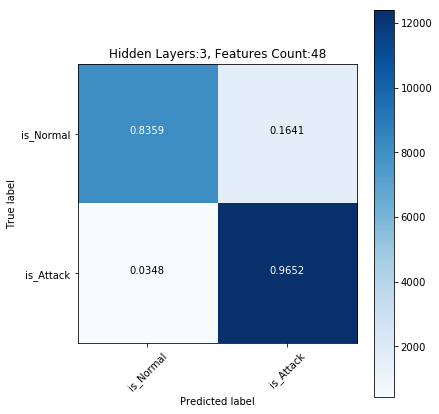

In [16]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

Normalized confusion matrix
[[ 0.5144  0.4856]
 [ 0.046   0.954 ]]


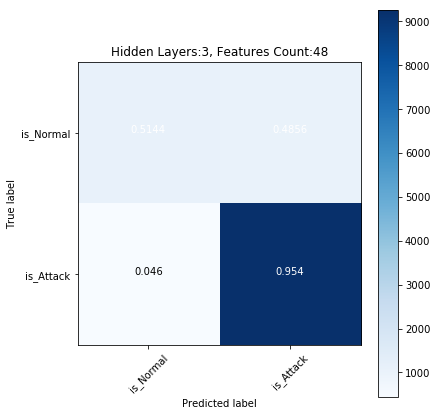

In [17]:
plot(actual_value = Train.actual_value_, pred_value = Train.pred_value_)

In [18]:
past_scores = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_scores_all-.pkl")

In [19]:
past_scores

epoch  train_score  test_score  test_score_20  \
no_of_features hidden_layers                                                  
1              1                  2     0.500000    0.583259       0.823207   
               1                  3     0.773810    0.853132       0.821350   
               1                  4     0.819444    0.873181       0.817215   
               1                  5     0.857143    0.885247       0.815274   
               1                  6     0.858730    0.886533       0.812489   
8              1                  2     0.552778    0.696460       0.657553   
               1                  3     0.641667    0.776393       0.669705   
               1                  4     0.681746    0.800435       0.688439   
               1                  5     0.791270    0.834634       0.718987   
               1                  6     0.851587    0.848829       0.738228   
               1                  7     0.872222    0.855305       0.746414   
               1                  8     0.892063    0.861693       0.757637   
               1                  9     0.909921    0.862890       0.759409   
32             1                  2     0.724603    0.734120       0.525485   
               1                  3     0.771825    0.750665       0.542785   
               1                  4     0.911905    0.814319       0.651308   
               1                  5     0.830952    0.786152       0.606245   
               1                  6     0.922619    0.814807       0.652827   
               1                  7     0.868651    0.796576       0.623460   
               1                  8     0.931349    0.815871       0.654430   
               1                  9     0.894048    0.806379       0.640928   
               1                 10     0.905952    0.809173       0.644810   
               1                 11     0.922222    0.812544       0.648692   
122            1                  2     0.679365    0.775328       0.778819   
               1                  3     0.798810    0.852466       0.768692   
               1                  4     0.860317    0.879702       0.804810   
               1                  5     0.885714    0.892965       0.813502   
               1                  6     0.894048    0.896425       0.816203   
1              3                  2     0.538492    0.430758       0.181603   
8              3                  2     0.486508    0.553584       0.777300   
               3                  3     0.734127    0.799104       0.784473   
               3                  4     0.774603    0.841820       0.804979   
               3                  5     0.785714    0.857745       0.814430   
               3                  6     0.811111    0.861382       0.805823   
               3                  7     0.843651    0.871540       0.804473   
               3                  8     0.869841    0.880988       0.799578   
               3                  9     0.894048    0.884847       0.796540   
32             3                  2     0.776190    0.749202       0.626414   
               3                  3     0.842857    0.786773       0.629705   
               3                  4     0.875000    0.803983       0.643122   
               3                  5     0.882937    0.805492       0.641857   
122            3                  2     0.722222    0.736072       0.587342   
               3                  3     0.858730    0.842486       0.737890   
               3                  4     0.903571    0.868701       0.771308   
1              5                  2     0.553968    0.430758       0.181603   
8              5                  2     0.423016    0.321061       0.499325   
               5                  3     0.540079    0.414257       0.487511   
               5                  4     0.620238    0.485318       0.471561   
               5                  6     0.679762    0.507630       0.443966   
 

In [ ]:
pgb = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
pgb.max().sort_values(by="test_score", ascending = False)

epoch  train_score  test_score  test_score_20  \
no_of_features hidden_layers                                                  
122            3                 12     0.950000    0.907337       0.859409   
32             3                 33     0.949603    0.900639       0.838565   
122            5                 10     0.919841    0.898998       0.867089   
               1                 22     0.967460    0.896425       0.816203   
32             5                 33     0.937698    0.895050       0.822363   
8              5                 33     0.925000    0.889993       0.822447   
1              1                 33     0.969841    0.886533       0.823207   
8              3                 33     0.948413    0.884847       0.832743   
32             1                 33     0.975794    0.865774       0.773502   
8              1                 33     0.967857    0.862890       0.759409   
1              3                 27     0.930952    0.782736       0.591983   
               5                 33     0.831349    0.658534       0.432658   

                              time_taken  
no_of_features hidden_layers              
122            3               31.049070  
32             3               35.120372  
122            5               27.521660  
               1               17.254168  
32             5               58.477479  
8              5               36.295973  
1              1               23.211684  
8              3               32.769451  
32             1               21.436236  
8              1               23.059453  
1              3               24.386522  
               5               40.437156

In [ ]:
pgb = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
pgb.min().sort_values(by="test_score", ascending = False)

In [ ]:
pgb = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
pgb.mean().sort_values(by="test_score", ascending = False)

In [ ]:
pgb = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
pgb.std().sort_values(by="test_score", ascending = False)